<a href="https://colab.research.google.com/github/mfrdixon/alpha-RNN/blob/master/Alpha_RNNs_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/drive/My Drive')

In [3]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
from numpy import random
import os# Generate switching data set
import random


# Imports for alpha_rnns 
from IPython import display
import tensorflow.compat.v1 as tf   
tf.disable_v2_behavior()
# Imports for stats


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.regularizers import l1,l2
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from alphaRNN import *

# To make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, eps=0.01):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    step_length=np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      mu[i*step_length:((i*step_length)+1)]=step_size*(-1)**i
     
    for i in range(1, length):
        sigma[i]=sigma[i-1] + mu[i] + eps*np.random.normal(0,1)
        
    return sigma   


In [0]:
def generate_vol_sample(length, sigma_0, n_steps, step_size, p, eps=0.01, shift=0):
    sigma = np.array([0]*length, dtype='float64')
    sigma[0]=sigma_0
    mu = np.array([0]*length, dtype='float64')
    phi = np.array([0]*length*p, dtype='float64').reshape(length,p)
    #phi2 = np.array([0]*length, dtype='float64')
    step_length=100 #np.int(np.floor(np.float(length)/(2.0*n_steps)))
    
    for i in range(2*n_steps):
      #mu[i*step_length:((i*step_length)+1)]=step_size #*(-1)**i
      mu[i*step_length:((i+1)*step_length)]= step_size*(-1)**i
      if i%2==0:  
        phi[i*step_length:((i+1)*step_length),:]= 0.02
        #phi2[i*step_length:((i+1)*step_length)]=1.0
      else:
        phi[i*step_length:((i+1)*step_length),:]=0.01
        #phi2[i*step_length:((i+1)*step_length)]=0.5
    for i in range(p, length):
        sigma[i]= mu[i-1] + np.random.normal(0,eps)
        for j in range(p):
          sigma[i]+=phi[i-1,j]*sigma[i-j]  
        
    return (sigma+shift)

In [0]:
p = 30 # the number of lags (in both the data and the models)
vols=generate_vol_sample(2000, 0.25, 15, 0.1, p, 1e-4, 0.13)[p:]

In [0]:
df = pd.DataFrame(vols, columns=['vol'])

In [8]:
use_features = ['vol'] 
target = 'vol'
n_steps = 10 # number of lags to include in the model

train_weight = 0.8
split = int(len(df)*train_weight)

df_train = df[use_features].iloc[:split]
print(df_train)
df_test = df[use_features].iloc[split:]

           vol
0     0.232030
1     0.234036
2     0.236036
3     0.238477
4     0.240405
...        ...
1571  0.149704
1572  0.153026
1573  0.156357
1574  0.159536
1575  0.162963

[1576 rows x 1 columns]


In [0]:
def get_lagged_features(value, n_steps):
    lag_list = []
    for lag in range(n_steps, 0, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [0]:


x_train_list = []
for use_feature in use_features:
    x_train_reg = get_lagged_features(df_train, n_steps).dropna()
    x_train_list.append(x_train_reg)
x_train_reg = pd.concat(x_train_list, axis=1)

col_ords = []
for i in range(n_steps):
    for j in range(len(use_features)):
        col_ords.append(i + j * n_steps)

x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list = []
for use_feature in use_features:
    x_test_reg = get_lagged_features(df_test, n_steps).dropna()
    x_test_list.append(x_test_reg)
x_test_reg = pd.concat(x_test_list, axis=1)

x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

In [0]:
print(x_train_reg.shape,y_train_reg.shape,x_test_reg.shape,y_test_reg.shape)

(1566, 10, 1) (1566, 1, 1) (384, 10, 1) (384, 1, 1)


In [0]:
train_batch_size = y_train_reg.shape[0]
test_batch_size = y_test_reg.shape[0]

In [0]:
print(train_batch_size)

1566


In [0]:
tf.get_collection('alpha_t')

[<tf.Tensor 'h_t_transposed/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_2/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_3/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_4/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_5/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_6/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_7/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_8/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_9/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_10/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_11/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_12/while/Sigmoid:0' shape=(?, 10) dtype=float64>,
 <tf.Tensor 'h_t_transposed_13/while/Sigmoid:0' shape=(?, 10) dtype=float64

In [0]:
#session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
#alpharnn = simpleAlphaRNN(input_dimensions, hidden_size)
#W_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
#b_output = tf.Variable(tf.truncated_normal(dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
#output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, alpharnn.h_t) 
#model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

#for model in models:
#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})
#y_predicted_ar =np.array([0]*y_predicted_t.shape[0], dtype='float64')
#for i in range(y_predicted_t.shape[0]):
  #y_predicted_ar[i]=y_predicted[i][n_steps-1][0]
  #MSE_test += mean_squared_error(y_test[:,0],y_predicted_ar[i])

#y_predicted = session.run(output, feed_dict={alpharnn.input_layer: x_train_reg})
#y_predicted_ar_train =np.array([0]*y_predicted.shape[0], dtype='float64')
#for i in range(y_predicted.shape[0]):
  #y_predicted_ar_train[i]=y_predicted[i][n_steps-1][0]
  #MSE_train += mean_squared_error(y_train[:,0],y_predicted_ar_train[i])
  
  #MSE_train_alpha = MSE_train/n_splits
  #print("MSE train alpha = " + str(MSE_train_alpha))
  #MSE_test_alpha = MSE_test/n_splits
  #print("MSE test alpha = " + str(MSE_test_alpha))
  #MSE_train_alpha_std = np.math.sqrt(MSE_train_alpha/(n_splits-1))
  #MSE_test_alpha_std = np.math.sqrt(MSE_test_alpha/(n_splits-1))
  #print("MSE_train_alpha_std = " + str(MSE_train_alpha_std))
  #print("MSE_test_alpha_std = " + str(MSE_test_alpha_std))

## Time series cross-val

Just use val_loss for model selection



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch  0 / 2000 :  	Training Loss: 0.29826 	Validation Loss: 0.18000
Epoch  50 / 2000 :  	Training Loss: 0.09048 	Validation Loss: 0.09551
Epoch  100 / 2000 :  	Training Loss: 0.05443 	Validation Loss: 0.05928
Epoch  150 / 2000 :  	Training Loss: 0.04894 	Validation Loss: 0.05841
Epoch  200 / 2000 :  	Training Loss: 0.04436 	Validation Loss: 0.05419
Epoch  250 / 2000 :  	Training Loss: 0.03942 	Validation Loss: 0.04906
Epoch  300 / 2000 :  	Training Loss: 0.03335 	Validation Loss: 0.04264
Epoch  350 / 2000 :  	Training Loss: 0.02579 	Validation Loss: 0.03454
Epoch  400 / 2000 :  	Training Loss: 0.01946 	Validation Loss: 0.02776
Epoch  450 / 2000 :  	Training Loss: 0.01588 	Validation Loss: 0.02401
Epoch  500 / 2000 :  	Training Loss: 0.01399 	Validation Loss: 0.02207
Epoch  550 / 2000 :  	Training Loss: 0.01292 	Validation Loss: 0.02100
Epoch  600 / 2000 :  	Training Loss: 0.01230 	Validation 

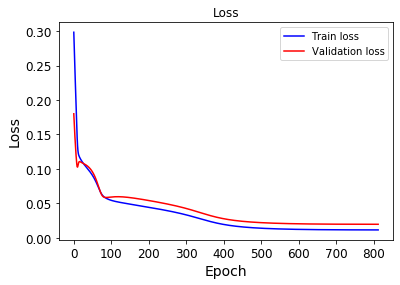

Epoch  0 / 2000 :  	Training Loss: 0.21511 	Validation Loss: 0.17347
Epoch  50 / 2000 :  	Training Loss: 0.03191 	Validation Loss: 0.02839
Epoch  100 / 2000 :  	Training Loss: 0.01912 	Validation Loss: 0.01758
Epoch  150 / 2000 :  	Training Loss: 0.01671 	Validation Loss: 0.01561
Epoch  200 / 2000 :  	Training Loss: 0.01575 	Validation Loss: 0.01481
Epoch  250 / 2000 :  	Training Loss: 0.01534 	Validation Loss: 0.01448
Epoch  300 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01434
Epoch  350 / 2000 :  	Training Loss: 0.01510 	Validation Loss: 0.01429
Early stopping


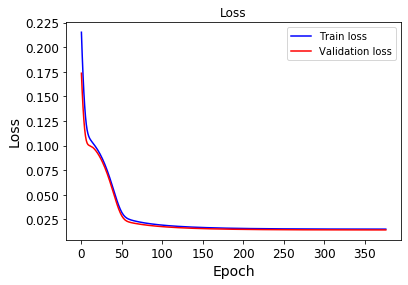

Epoch  0 / 2000 :  	Training Loss: 0.19718 	Validation Loss: 0.26162
Epoch  50 / 2000 :  	Training Loss: 0.05132 	Validation Loss: 0.05327
Epoch  100 / 2000 :  	Training Loss: 0.03947 	Validation Loss: 0.03980
Epoch  150 / 2000 :  	Training Loss: 0.02290 	Validation Loss: 0.02138
Epoch  200 / 2000 :  	Training Loss: 0.01676 	Validation Loss: 0.01433
Epoch  250 / 2000 :  	Training Loss: 0.01541 	Validation Loss: 0.01268
Epoch  300 / 2000 :  	Training Loss: 0.01511 	Validation Loss: 0.01227
Epoch  350 / 2000 :  	Training Loss: 0.01507 	Validation Loss: 0.01219
Early stopping


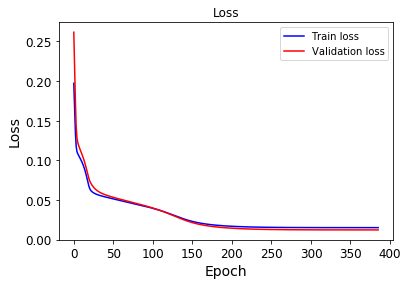

Epoch  0 / 2000 :  	Training Loss: 0.19553 	Validation Loss: 0.17975
Epoch  50 / 2000 :  	Training Loss: 0.01817 	Validation Loss: 0.02211
Epoch  100 / 2000 :  	Training Loss: 0.01469 	Validation Loss: 0.01918
Epoch  150 / 2000 :  	Training Loss: 0.01413 	Validation Loss: 0.01878
Epoch  200 / 2000 :  	Training Loss: 0.01405 	Validation Loss: 0.01875
Early stopping


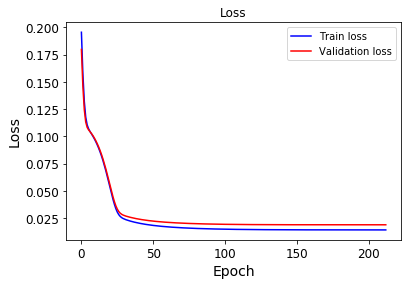

Epoch  0 / 2000 :  	Training Loss: 0.18727 	Validation Loss: 0.14389
Epoch  50 / 2000 :  	Training Loss: 0.04380 	Validation Loss: 0.04306
Epoch  100 / 2000 :  	Training Loss: 0.01944 	Validation Loss: 0.01782
Epoch  150 / 2000 :  	Training Loss: 0.01557 	Validation Loss: 0.01377
Epoch  200 / 2000 :  	Training Loss: 0.01528 	Validation Loss: 0.01347
Early stopping


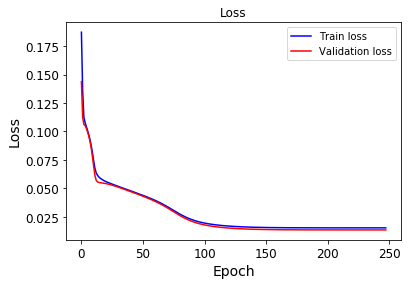

Epoch  0 / 2000 :  	Training Loss: 0.29595 	Validation Loss: 0.17852
Epoch  50 / 2000 :  	Training Loss: 0.07616 	Validation Loss: 0.08694
Epoch  100 / 2000 :  	Training Loss: 0.02685 	Validation Loss: 0.02902
Epoch  150 / 2000 :  	Training Loss: 0.01790 	Validation Loss: 0.02317
Epoch  200 / 2000 :  	Training Loss: 0.01451 	Validation Loss: 0.02115
Epoch  250 / 2000 :  	Training Loss: 0.01293 	Validation Loss: 0.02021
Epoch  300 / 2000 :  	Training Loss: 0.01212 	Validation Loss: 0.01975
Epoch  350 / 2000 :  	Training Loss: 0.01172 	Validation Loss: 0.01955
Epoch  400 / 2000 :  	Training Loss: 0.01153 	Validation Loss: 0.01948
Early stopping


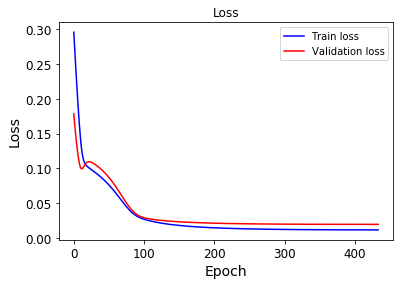

Epoch  0 / 2000 :  	Training Loss: 0.21345 	Validation Loss: 0.17211
Epoch  50 / 2000 :  	Training Loss: 0.03324 	Validation Loss: 0.03077
Epoch  100 / 2000 :  	Training Loss: 0.01835 	Validation Loss: 0.01692
Epoch  150 / 2000 :  	Training Loss: 0.01619 	Validation Loss: 0.01512
Epoch  200 / 2000 :  	Training Loss: 0.01549 	Validation Loss: 0.01457
Epoch  250 / 2000 :  	Training Loss: 0.01522 	Validation Loss: 0.01437
Epoch  300 / 2000 :  	Training Loss: 0.01512 	Validation Loss: 0.01431
Early stopping


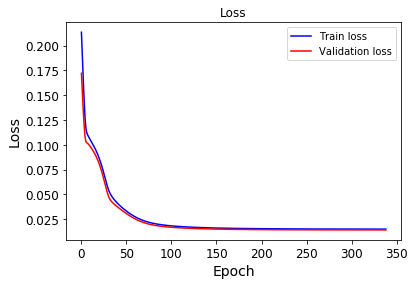

Epoch  0 / 2000 :  	Training Loss: 0.18879 	Validation Loss: 0.25041
Epoch  50 / 2000 :  	Training Loss: 0.04474 	Validation Loss: 0.04591
Epoch  100 / 2000 :  	Training Loss: 0.02281 	Validation Loss: 0.02125
Epoch  150 / 2000 :  	Training Loss: 0.01666 	Validation Loss: 0.01421
Epoch  200 / 2000 :  	Training Loss: 0.01513 	Validation Loss: 0.01237
Epoch  250 / 2000 :  	Training Loss: 0.01498 	Validation Loss: 0.01216
Epoch  300 / 2000 :  	Training Loss: 0.01498 	Validation Loss: 0.01214
Early stopping


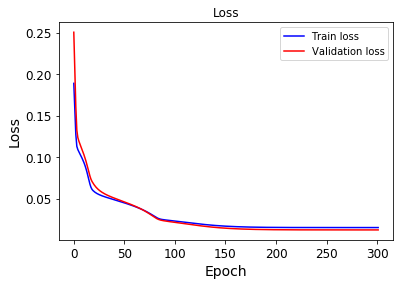

Epoch  0 / 2000 :  	Training Loss: 0.18387 	Validation Loss: 0.16927
Epoch  50 / 2000 :  	Training Loss: 0.03446 	Validation Loss: 0.03829
Epoch  100 / 2000 :  	Training Loss: 0.01700 	Validation Loss: 0.02153
Epoch  150 / 2000 :  	Training Loss: 0.01433 	Validation Loss: 0.01904
Epoch  200 / 2000 :  	Training Loss: 0.01424 	Validation Loss: 0.01899
Early stopping


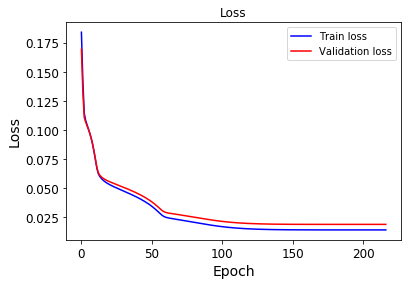

Epoch  0 / 2000 :  	Training Loss: 0.18402 	Validation Loss: 0.14166
Epoch  50 / 2000 :  	Training Loss: 0.02659 	Validation Loss: 0.02532
Epoch  100 / 2000 :  	Training Loss: 0.01581 	Validation Loss: 0.01404
Epoch  150 / 2000 :  	Training Loss: 0.01519 	Validation Loss: 0.01338
Early stopping


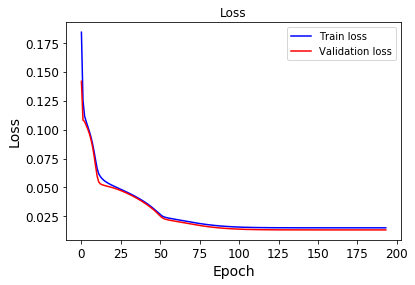

Epoch  0 / 2000 :  	Training Loss: 0.30436 	Validation Loss: 0.18394
Epoch  50 / 2000 :  	Training Loss: 0.05817 	Validation Loss: 0.06040
Epoch  100 / 2000 :  	Training Loss: 0.02398 	Validation Loss: 0.03152
Epoch  150 / 2000 :  	Training Loss: 0.01634 	Validation Loss: 0.02368
Epoch  200 / 2000 :  	Training Loss: 0.01342 	Validation Loss: 0.02110
Epoch  250 / 2000 :  	Training Loss: 0.01219 	Validation Loss: 0.02013
Epoch  300 / 2000 :  	Training Loss: 0.01167 	Validation Loss: 0.01976
Epoch  350 / 2000 :  	Training Loss: 0.01148 	Validation Loss: 0.01962
Epoch  400 / 2000 :  	Training Loss: 0.01142 	Validation Loss: 0.01959
Early stopping


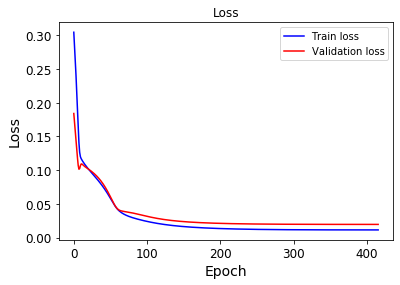

Epoch  0 / 2000 :  	Training Loss: 0.23184 	Validation Loss: 0.18726
Epoch  50 / 2000 :  	Training Loss: 0.02597 	Validation Loss: 0.02374
Epoch  100 / 2000 :  	Training Loss: 0.01711 	Validation Loss: 0.01585
Epoch  150 / 2000 :  	Training Loss: 0.01557 	Validation Loss: 0.01464
Epoch  200 / 2000 :  	Training Loss: 0.01525 	Validation Loss: 0.01441
Epoch  250 / 2000 :  	Training Loss: 0.01518 	Validation Loss: 0.01435
Early stopping


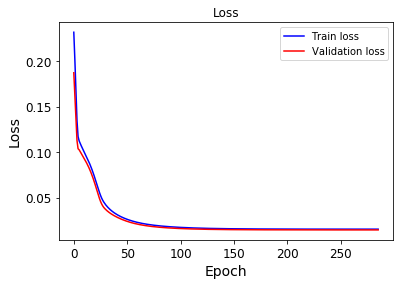

Epoch  0 / 2000 :  	Training Loss: 0.20167 	Validation Loss: 0.26757
Epoch  50 / 2000 :  	Training Loss: 0.02926 	Validation Loss: 0.02838
Epoch  100 / 2000 :  	Training Loss: 0.01739 	Validation Loss: 0.01514
Epoch  150 / 2000 :  	Training Loss: 0.01523 	Validation Loss: 0.01249
Epoch  200 / 2000 :  	Training Loss: 0.01497 	Validation Loss: 0.01216
Epoch  250 / 2000 :  	Training Loss: 0.01495 	Validation Loss: 0.01211
Early stopping


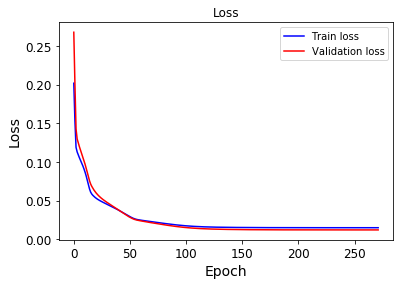

Epoch  0 / 2000 :  	Training Loss: 0.19548 	Validation Loss: 0.17969
Epoch  50 / 2000 :  	Training Loss: 0.01603 	Validation Loss: 0.02053
Epoch  100 / 2000 :  	Training Loss: 0.01424 	Validation Loss: 0.01901
Epoch  150 / 2000 :  	Training Loss: 0.01417 	Validation Loss: 0.01891
Epoch  200 / 2000 :  	Training Loss: 0.01417 	Validation Loss: 0.01889
Early stopping


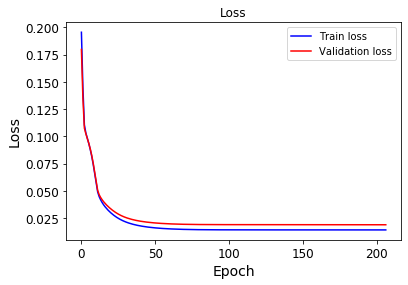

Epoch  0 / 2000 :  	Training Loss: 0.18082 	Validation Loss: 0.13942
Epoch  50 / 2000 :  	Training Loss: 0.01632 	Validation Loss: 0.01444
Epoch  100 / 2000 :  	Training Loss: 0.01509 	Validation Loss: 0.01331
Epoch  150 / 2000 :  	Training Loss: 0.01506 	Validation Loss: 0.01329
Early stopping


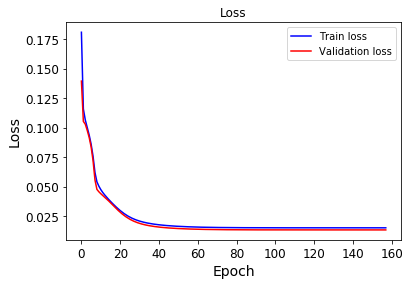

Epoch  0 / 2000 :  	Training Loss: 0.27781 	Validation Loss: 0.16710
Epoch  50 / 2000 :  	Training Loss: 0.04001 	Validation Loss: 0.04695
Epoch  100 / 2000 :  	Training Loss: 0.02211 	Validation Loss: 0.02976
Epoch  150 / 2000 :  	Training Loss: 0.01458 	Validation Loss: 0.02202
Epoch  200 / 2000 :  	Training Loss: 0.01246 	Validation Loss: 0.02037
Epoch  250 / 2000 :  	Training Loss: 0.01177 	Validation Loss: 0.01988
Epoch  300 / 2000 :  	Training Loss: 0.01153 	Validation Loss: 0.01969
Epoch  350 / 2000 :  	Training Loss: 0.01145 	Validation Loss: 0.01963
Early stopping


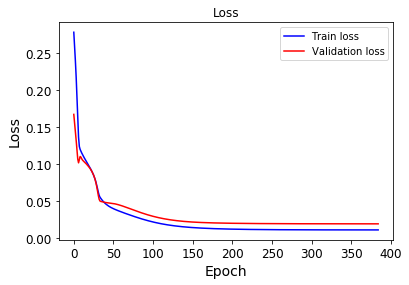

Epoch  0 / 2000 :  	Training Loss: 0.19329 	Validation Loss: 0.15589
Epoch  50 / 2000 :  	Training Loss: 0.02862 	Validation Loss: 0.02637
Epoch  100 / 2000 :  	Training Loss: 0.01678 	Validation Loss: 0.01561
Epoch  150 / 2000 :  	Training Loss: 0.01539 	Validation Loss: 0.01448
Epoch  200 / 2000 :  	Training Loss: 0.01520 	Validation Loss: 0.01434
Early stopping


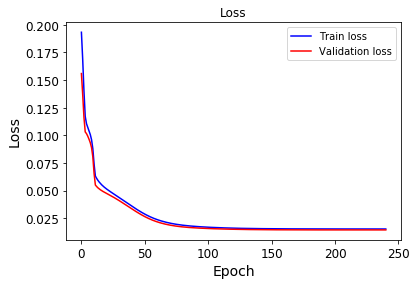

Epoch  0 / 2000 :  	Training Loss: 0.18299 	Validation Loss: 0.24258
Epoch  50 / 2000 :  	Training Loss: 0.01773 	Validation Loss: 0.01574
Epoch  100 / 2000 :  	Training Loss: 0.01501 	Validation Loss: 0.01223
Epoch  150 / 2000 :  	Training Loss: 0.01491 	Validation Loss: 0.01208
Early stopping


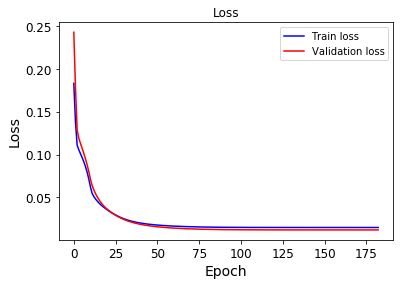

Epoch  0 / 2000 :  	Training Loss: 0.16700 	Validation Loss: 0.15424
Epoch  50 / 2000 :  	Training Loss: 0.01531 	Validation Loss: 0.01985
Epoch  100 / 2000 :  	Training Loss: 0.01418 	Validation Loss: 0.01891
Early stopping


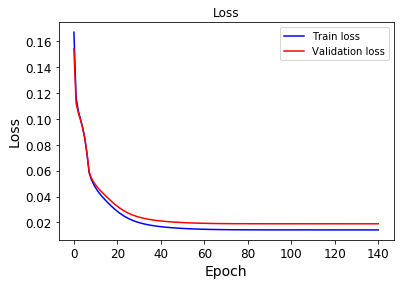

Epoch  0 / 2000 :  	Training Loss: 0.17137 	Validation Loss: 0.13315
Epoch  50 / 2000 :  	Training Loss: 0.01564 	Validation Loss: 0.01384
Epoch  100 / 2000 :  	Training Loss: 0.01514 	Validation Loss: 0.01334
Early stopping


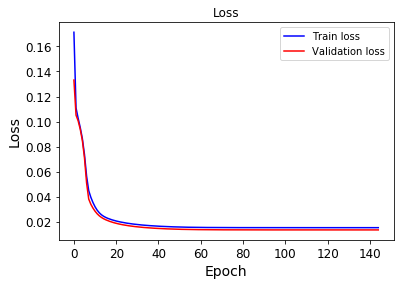

Epoch  0 / 2000 :  	Training Loss: 0.28591 	Validation Loss: 0.17216
Epoch  50 / 2000 :  	Training Loss: 0.02945 	Validation Loss: 0.03577
Epoch  100 / 2000 :  	Training Loss: 0.01530 	Validation Loss: 0.02266
Epoch  150 / 2000 :  	Training Loss: 0.01248 	Validation Loss: 0.02047
Epoch  200 / 2000 :  	Training Loss: 0.01178 	Validation Loss: 0.01992
Epoch  250 / 2000 :  	Training Loss: 0.01154 	Validation Loss: 0.01971
Epoch  300 / 2000 :  	Training Loss: 0.01146 	Validation Loss: 0.01965
Early stopping


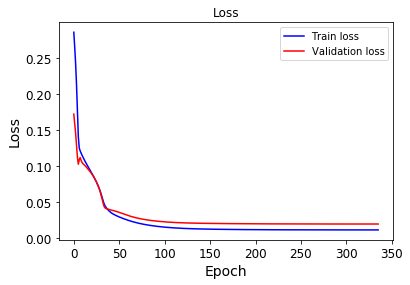

Epoch  0 / 2000 :  	Training Loss: 0.20362 	Validation Loss: 0.16415
Epoch  50 / 2000 :  	Training Loss: 0.02306 	Validation Loss: 0.02081
Epoch  100 / 2000 :  	Training Loss: 0.01574 	Validation Loss: 0.01475
Epoch  150 / 2000 :  	Training Loss: 0.01524 	Validation Loss: 0.01436
Early stopping


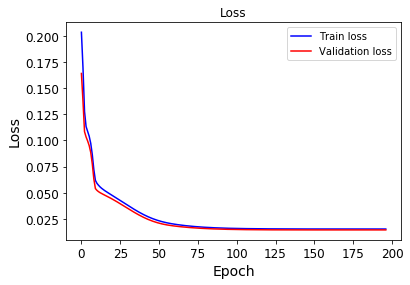

Epoch  0 / 2000 :  	Training Loss: 0.16662 	Validation Loss: 0.21997
Epoch  50 / 2000 :  	Training Loss: 0.01660 	Validation Loss: 0.01432
Epoch  100 / 2000 :  	Training Loss: 0.01495 	Validation Loss: 0.01213
Epoch  150 / 2000 :  	Training Loss: 0.01492 	Validation Loss: 0.01210
Early stopping


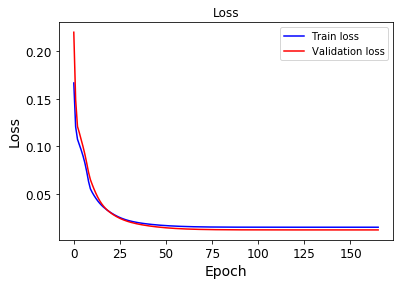

Epoch  0 / 2000 :  	Training Loss: 0.16659 	Validation Loss: 0.15382
Epoch  50 / 2000 :  	Training Loss: 0.01481 	Validation Loss: 0.01945
Epoch  100 / 2000 :  	Training Loss: 0.01420 	Validation Loss: 0.01892
Early stopping


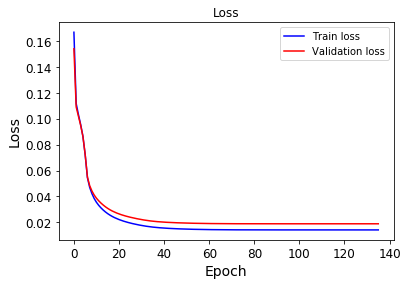

Epoch  0 / 2000 :  	Training Loss: 0.15214 	Validation Loss: 0.12105
Epoch  50 / 2000 :  	Training Loss: 0.01517 	Validation Loss: 0.01338
Epoch  100 / 2000 :  	Training Loss: 0.01514 	Validation Loss: 0.01334
Early stopping


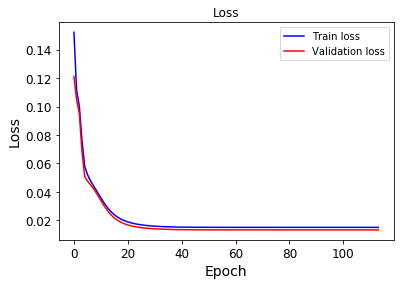

In [14]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits)
hidden_sizes=[1,2,5,10,20]
i=0
val_losses=[]
batch_size  = 100
input_dimensions=1
for hidden_size in hidden_sizes:
 val_loss =0
 for train_fold, test_fold in tscv.split(x_train_reg):
  x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
  y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
  session = tf.Session()
  # Add an additional layer on top of each of the hidden state outputs
  alpharnn_t = simpleAlphaRNN(input_dimensions, hidden_size)
  #models.append(train(alpharnn_t, x_train, x_test, y_train, y_test)) 
  model, val_loss_=train(session, alpharnn_t, x_train, x_test, y_train, y_test, max_epochs=2000, batch_size=int(batch_size/n_splits))
  val_loss+=val_loss_
 val_losses.append(val_loss)
  
  

![alt text](https://)Pick the model with the lowest val loss sum over folds. you can *not* use the test set for model selection! This would be cheating


> Indented block



In [26]:
#Pick the model with the lowest val_loss. Retrain it on all data and then perform prediction
val, idx = min((val, idx) for (idx, val) in enumerate(val_losses))
print(hidden_sizes[idx])

5


### Train on all training data with best model and predict on test set (no rolling)

Epoch  0 / 2000 :  	Training Loss: 0.22121 	Validation Loss: 0.22860
Epoch  50 / 2000 :  	Training Loss: 0.02242 	Validation Loss: 0.02172
Epoch  100 / 2000 :  	Training Loss: 0.01538 	Validation Loss: 0.01414
Epoch  150 / 2000 :  	Training Loss: 0.01482 	Validation Loss: 0.01348
Epoch  200 / 2000 :  	Training Loss: 0.01480 	Validation Loss: 0.01345
Early stopping


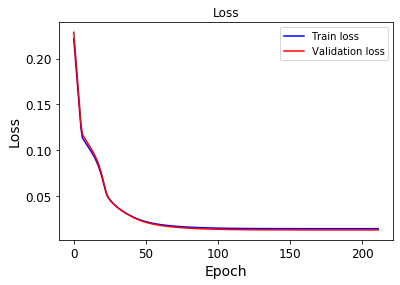

In [28]:
session = tf.Session()
alpharnn = simpleAlphaRNN(input_dimensions, hidden_sizes[idx])
model,_=train(session, alpharnn, x_train_reg, x_test_reg, y_train_reg, y_test_reg) 

In [0]:
y_predicted_t = session.run(model.output, feed_dict={model.input_layer: x_test_reg})
y_predicted_ar_t=np.array([0]*y_predicted_t.shape[0], dtype='float64')
for i in range(y_predicted_t.shape[0]):
     y_predicted_ar_t[i]=y_predicted_t[i][n_steps-1][0]

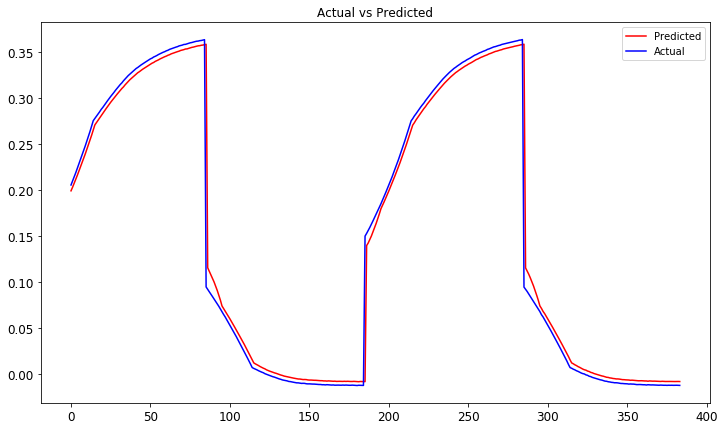

In [30]:
fig = plt.figure(figsize=(12,7))
plt.plot(y_predicted_ar_t, color='r', label='Predicted')
plt.plot(y_test_reg.flatten(),'b', label='Actual')
plt.legend(loc=0)
plt.title('Actual vs Predicted')
plt.show()

In [40]:
mse = mean_squared_error(y_test_reg[:,0],y_predicted_ar_t)
print(mse)

0.000476678978445462


#Comparison with Keras models


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping

In [0]:
x_train_reg = pd.concat(x_train_list, axis=1)
x_train_reg = x_train_reg.iloc[:, col_ords]
y_train_reg = df_train.loc[x_train_reg.index, [target]].values
x_train_reg = np.reshape(x_train_reg.values, (x_train_reg.shape[0], np.int(x_train_reg.shape[1] / len(use_features)), len(use_features)))

In [0]:
x_test_reg = pd.concat(x_test_list, axis=1)
x_test_reg = x_test_reg.iloc[:, col_ords]
y_test_reg = df_test.loc[x_test_reg.index, [target]].values
x_test_reg = np.reshape(x_test_reg.values, (x_test_reg.shape[0], np.int(x_test_reg.shape[1]/len(use_features)), len(use_features)))

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=1e-3)

In [0]:
def RNN_model2(n_units=10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(SimpleRNN(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def GRU_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(GRU(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

def LSTM_model2(n_units = 10, l1_reg=0):
    reg_model = Sequential()
    reg_model.add(LSTM(n_units, activation='relu', input_shape=(x_train_reg.shape[1], x_train_reg.shape[-1]), unroll=True))
    #LPNorm.build_loss(p = float('inf'))
    reg_model.add(Dense(1, kernel_initializer='normal', kernel_regularizer=l1(l1_reg)))
    #reg_model.add(Dropout(0.2))
    reg_model.compile(loss='mean_squared_error', optimizer='adam')
    return reg_model

In [38]:
n_units = [1,2,5,10,20]
l1_reg = [0]  #[0, 0.001]   #0.01, 0.1]
#param_grid = dict(epochs=epochs,batch_size =batch_size)
                  #n_neurons=n_neurons)
                  #optimizers=optimizers,
                  #n_neurons = n_neurons)
#learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
#momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
#weight_constraint = [1, 2, 3, 4, 5]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
tscv = TimeSeriesSplit(n_splits = 5)
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
#X_train, X_test, y_train, y_test = train_test_split(x_train_reg, y_train_reg, test_size=0.5, random_state=0) 
print("Hyper parameter tuning for RNN...")
model = KerasRegressor(build_fn=RNN_model2, epochs=2000, batch_size=100, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2)
grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with %r" % (mean, stdev, param))
# Manual CV
nodes = grid_result.best_params_['n_units']
l1_reg = grid_result.best_params_['l1_reg']
#n_units = [10, 20, 30, 40, 50, 60, 100]

Hyper parameter tuning for RNN...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

In [45]:
param_grid = dict(n_units=n_units,l1_reg=l1_reg) 
n_splits = 5
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0
TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
tscv = TimeSeriesSplit()
nodes = 5
for train_fold, test_fold in tscv.split(x_train_reg): 
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    rnn_model = RNN_model2(nodes,l1_reg)
   
    rnn_fit = rnn_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    rnn_pred_train = rnn_model.predict(x_train, verbose=0)
    rnn_pred_test = rnn_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], rnn_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], rnn_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
rnn_model.summary()
MSE_train_ave = MSE_train/n_splits
MSE_train_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_ave = MSE_test/n_splits
MSE_test_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_rnn_ave = " + str(MSE_train_ave))
print("MSE_test_rnn_ave = " + str(MSE_test_ave))
print("MSE_train_rnn_std = " + str(MSE_train_std))
print("MSE_test_rnn_std = " + str(MSE_test_std))
print("p = " + str(p))

rnn_model = RNN_model2(nodes,l1_reg)
rnn_fit = rnn_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
rnn_pred_test = rnn_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],rnn_pred_test[:,0])
print("RNN test data mse = " + str(mse))
print("RNN test std mse = " + str(np.sqrt(mse)))
rnn_model.summary()












Epoch 1/2000





330/330 [==============================] - 2s 7ms/step - loss: 0.0424
Epoch 2/2000
330/330 [==============================] - 0s 36us/step - loss: 0.0409
Epoch 3/2000
330/330 [==============================] - 0s 34us/step - loss: 0.0394
Epoch 4/2000
330/330 [==============================] - 0s 29us/step - loss: 0.0379
Epoch 5/2000
330/330 [==============================] - 0s 28us/step - loss: 0.0364
Epoch 6/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0350
Epoch 7/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0336
Epoch 8/2000
330/330 [==============================] - 0s 26us/step - loss: 0.0323
Epoch 9/2000
330/330 [==============================] - 0s 27us/step - loss: 0.0309
Epoch 10/2000
330/330 [==============================] - 0s 27us/step - loss: 0.0296
Epoch 11/2000
330/330 [==============================] - 0s 33us/step - loss: 0.0283
Epoch 12/2000
330/330 [==============================] - 0s 33

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


330/330 [==============================] - 0s 46us/step - loss: 0.0172
Epoch 20/2000
330/330 [==============================] - 0s 37us/step - loss: 0.0159
Epoch 21/2000
330/330 [==============================] - 0s 38us/step - loss: 0.0147
Epoch 22/2000
330/330 [==============================] - 0s 42us/step - loss: 0.0134
Epoch 23/2000
330/330 [==============================] - 0s 33us/step - loss: 0.0122
Epoch 24/2000
330/330 [==============================] - 0s 36us/step - loss: 0.0110
Epoch 25/2000
330/330 [==============================] - 0s 44us/step - loss: 0.0097
Epoch 26/2000
330/330 [==============================] - 0s 41us/step - loss: 0.0084
Epoch 27/2000
330/330 [==============================] - 0s 35us/step - loss: 0.0072
Epoch 28/2000
330/330 [==============================] - 0s 40us/step - loss: 0.0062
Epoch 29/2000
330/330 [==============================] - 0s 39us/step - loss: 0.0054
Epoch 30/2000
330/330 [==============================] - 0s 38us/step - loss: 0

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


656/656 [==============================] - 0s 30us/step - loss: 0.0191
Epoch 13/2000
656/656 [==============================] - 0s 30us/step - loss: 0.0168
Epoch 14/2000
656/656 [==============================] - 0s 26us/step - loss: 0.0148
Epoch 15/2000
656/656 [==============================] - 0s 25us/step - loss: 0.0132
Epoch 16/2000
656/656 [==============================] - 0s 33us/step - loss: 0.0118
Epoch 17/2000
656/656 [==============================] - 0s 37us/step - loss: 0.0108
Epoch 18/2000
656/656 [==============================] - 0s 30us/step - loss: 0.0099
Epoch 19/2000
656/656 [==============================] - 0s 29us/step - loss: 0.0092
Epoch 20/2000
656/656 [==============================] - 0s 26us/step - loss: 0.0086
Epoch 21/2000
656/656 [==============================] - 0s 22us/step - loss: 0.0079
Epoch 22/2000
656/656 [==============================] - 0s 23us/step - loss: 0.0073
Epoch 23/2000
656/656 [==============================] - 0s 25us/step - loss: 0

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


982/982 [==============================] - 0s 25us/step - loss: 0.0076
Epoch 11/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0056
Epoch 12/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0039
Epoch 13/2000
982/982 [==============================] - 0s 21us/step - loss: 0.0028
Epoch 14/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0022
Epoch 15/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0019
Epoch 16/2000
982/982 [==============================] - 0s 22us/step - loss: 0.0018
Epoch 17/2000
982/982 [==============================] - 0s 26us/step - loss: 0.0017
Epoch 18/2000
982/982 [==============================] - 0s 24us/step - loss: 0.0016
Epoch 19/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0015
Epoch 20/2000
982/982 [==============================] - 0s 23us/step - loss: 0.0014
Epoch 21/2000
982/982 [==============================] - 0s 23us/step - loss: 0

IndexError: ignored

In [0]:
print("Cross Validating LSTM with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    lstm_model = LSTM_model2(nodes,l1_reg)
   
    lstm_fit = lstm_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    lstm_pred_train = lstm_model.predict(x_train, verbose=0)
    lstm_pred_test = lstm_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], lstm_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], lstm_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
lstm_model.summary()
MSE_train_lstm_ave = MSE_train/n_splits
MSE_test_lstm_ave = MSE_test/n_splits
MSE_train_lstm_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_lstm_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_lstm_ave = " + str(MSE_train_lstm_ave))
print("MSE_test_lstm_ave = " + str(MSE_test_lstm_ave))
print("MSE_train_lmst_std = " + str(MSE_train_lstm_std))
print("MSE_test_lmst_std = " + str(MSE_test_lstm_std))

#print("neurons = " + str(n_steps))
#print("p = " + str(p))
#print("neurons = " + str(n_steps))
#print("l1 reg = 0")
# measure performane of test data using hyperparameters of best model
lstm_model = LSTM_model2(nodes,l1_reg)
lstm_fit = lstm_model.fit(x_test_reg,y_test_reg, epochs=500, batch_size=100, callbacks=[es])
lstm_pred_test = lstm_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],lstm_pred_test[:,0])
print("LSTM test data mse = " + str(mse))
print("LSTM test std mse =  " + str(np.math.sqrt(mse)))
#score = cross_val_score(y_test_reg[:,0],g
lstm_model.summary()


Cross Validating LSTM with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0605
Epoch 2/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0559
Epoch 3/2000
261/261 [==============================] - 0s 165us/step - loss: 0.0512
Epoch 4/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0460
Epoch 5/2000
261/261 [==============================] - 0s 167us/step - loss: 0.0407
Epoch 6/2000
261/261 [==============================] - 0s 166us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 163us/step - loss: 0.0271
Epoch 8/2000
261/261 [==============================] - 0s 173us/step - loss: 0.0182
Epoch 9/2000
261/261 [==============================] - 0s 213us/step - loss: 0.0103
Epoch 10/2000
261/261 [==============================] - 0s 177us/step - loss: 0.0056
Epoch 11/2000
261/261 [==============================] - 0s 180us/step - loss: 0.0064
Epoch 12/2000

ValueError: ignored

In [0]:
print("Cross Validating GRU with optmized parameters....")
#kf = KFold(n_splits)
#kf.get_n_splits(x_train_reg)
MSE_train = 0
MSE_test = 0 
for train_fold, test_fold in tscv.split(x_train_reg):
    x_train, x_test = x_train_reg[train_fold], x_train_reg[test_fold]
    y_train, y_test = y_train_reg[train_fold], y_train_reg[test_fold]
    gru_model = GRU_model2(nodes,l1_reg)
   
    gru_fit = gru_model.fit(x_train,y_train, epochs=2000, batch_size=100, callbacks=[es])
    gru_pred_train = gru_model.predict(x_train, verbose=0)
    gru_pred_test = gru_model.predict(x_test, verbose=0) 

    # hyper parameter turning
    #MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:,0])
    MSE_train += mean_squared_error(y_train[:,0], gru_pred_train[:,0])
    MSE_test += mean_squared_error(y_test[:,0], gru_pred_test[:,0])
    #MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:,0])
    
gru_model.summary()
MSE_train_gru_ave = MSE_train/n_splits
MSE_test_gru_ave = MSE_test/n_splits
MSE_train_gru_std = np.math.sqrt(MSE_train/(n_splits-1))
MSE_test_gru_std = np.math.sqrt(MSE_test/(n_splits-1))
print("MSE_train_gru_ave = " + str(MSE_train_gru_ave))
print("MSE_test_gru_ave = " + str(MSE_test_gru_ave))
print("MSE_train_gru_std = " + str(MSE_train_gru_std))
print("MSE_test_gru_std = " + str(MSE_test_gru_std))

print("p = " + str(p))  
     
gru_model = GRU_model2(nodes,l1_reg)
gru_fit = gru_model.fit(x_test_reg,y_test_reg, epochs=2000, batch_size=100, callbacks=[es])
gru_pred_test = gru_model.predict(x_test_reg,verbose=1)
mse = mean_squared_error(y_test_reg[:,0],gru_pred_test[:,0])
print("GRU test data mse = " + str(mse))
print("GRU test std mse =  " + str(np.math.sqrt(mse)))
gru_model.summary()


Cross Validating GRU with optmized parameters....
Epoch 1/2000
261/261 [==============================] - 3s 12ms/step - loss: 0.0607
Epoch 2/2000
261/261 [==============================] - 0s 114us/step - loss: 0.0545
Epoch 3/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0488
Epoch 4/2000
261/261 [==============================] - 0s 112us/step - loss: 0.0439
Epoch 5/2000
261/261 [==============================] - 0s 124us/step - loss: 0.0392
Epoch 6/2000
261/261 [==============================] - 0s 139us/step - loss: 0.0345
Epoch 7/2000
261/261 [==============================] - 0s 117us/step - loss: 0.0301
Epoch 8/2000
261/261 [==============================] - 0s 121us/step - loss: 0.0252
Epoch 9/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0202
Epoch 10/2000
261/261 [==============================] - 0s 119us/step - loss: 0.0151
Epoch 11/2000
261/261 [==============================] - 0s 122us/step - loss: 0.0101
Epoch 12/2000


In [0]:
# make predictions with the trained LSTM
lstm_pred_train = lstm_model.predict(x_train_reg, verbose=1)
lstm_pred_test = lstm_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 74us/step


In [0]:
# make predictions with the trained RNN
rnn_pred_train = rnn_model.predict(x_train_reg, verbose=1)
rnn_pred_test = rnn_model.predict(x_test_reg, verbose=1)

384/384 [==============================] - 0s 47us/step


In [0]:
gru_pred_train = gru_model.predict(x_train_reg, verbose=1)
gru_pred_test = gru_model.predict(x_test_reg, verbose=1)

In [0]:
# calculate mean squared error of the plain RNN
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], rnn_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], rnn_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], gru_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], gru_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the GRU
MSE_train = mean_squared_error(df_train[use_feature][n_steps:], lstm_pred_train[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:],lstm_pred_test[:, 0])
print(MSE_test)

In [0]:
# calculate mean squared error of the alpha RNN

MSE_train = mean_squared_error(df_train[use_feature][n_steps:], train_losses[:, 0])
print(MSE_train)
MSE_test = mean_squared_error(df_test[use_feature][n_steps:], validation_losses[:, 0])
print(MSE_test)

ValueError: ignored

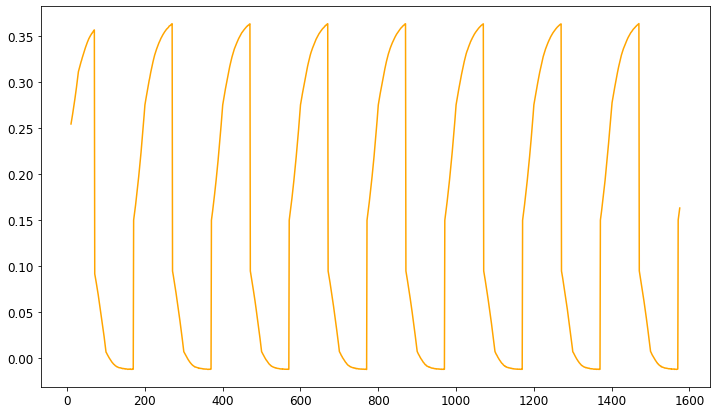

In [0]:
fig = plt.figure(figsize=(12,7))
train_line_real = plt.plot(df_train.index[n_steps:], df_train[use_feature][n_steps:], color="orange", label="Observed (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], lstm_pred_train[:, 0], color="red", label="LSTM Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], rnn_pred_train[:, 0], color="blue", label="RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:], gru_pred_train[:, 0], color="black", label="GRU Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_train, color='green', label="alpha RNN Predict (Training)")
train_line_pred = plt.plot(df_train.index[n_steps:],y_predicted_ar_trian_t, color="yellow", label="alpha_t RNN Predict (Training)" )

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Training)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

fig = plt.figure(figsize=(12,7))
test_line_real = plt.plot(df_test.index[n_steps:], df_test[use_feature][n_steps:], color="orange", label="Observed (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="red", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], rnn_pred_test[:, 0], color="blue", label="RNN Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], gru_pred_test[:, 0], color="black", label="GRU Predict (Testing)")
test_line_pred = plt.plot(df_test.index[n_steps:], y_predicted_ar,color="green", label="alpha RNN Predict (Testing)")
test_line_pred = plt.plot(df_test,index[n_steps:], y_predicted_ar_t, color="yellow", label= "alpha_t RNN Predict (Testing)")
# train_line_pred = plt.plot(session.run(output, feed_dict={alpharnn.input_layer: x_test_reg})

plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model (Testing)', fontsize=16)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Y', fontsize=20)

plt.show()